In [1]:
# Set the matplotlib backend and make the plots a bit bigger
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

import sys
#sys.path.insert(0,os.path.expanduser("~/g2full/GSASII/"))
#import GSASIIscriptable as G2sc

import re
from lmfit.models import GaussianModel, PolynomialModel, LorentzianModel, ExponentialModel, LinearModel
from lmfit import Parameters, fit_report, minimize, Model
from lmfit.model import save_modelresult, load_modelresult

import pandas as pd

import pyFAI
import numpy as np
import imageio
import matplotlib.pyplot as plt
sys.path.append("../../src/diamond_analysis")
sys.path.append("../../src/xrd")

from load_data import list_runs, load_tiff
from integrate_quads import integrate1d, integrate2d
from combine_quads import merge_four_quads, peaks_from_file, combine_patterns
from peak_shapes import *
quad_scale = np.loadtxt("../../.data_LW03/instprm/quad_scale_LW03.txt")

wavelength = 1.3051 * 10e-10

### This notebook makes use of the pyFAI package to azimuthaly integrate XRD spectra. 
Documentation of the package can be found [here](https://pyfai.readthedocs.io/en/master/index.html)

In [2]:
# define the data directory
dir_data = "../../.data_LW03"

# the logbook file
logbook = "../../.data_LW03/logbook_LW03_subset.ods"

# the calibration .poni files created by Dioptas
poni_file_q0 = "../../.data_LW03/poni/Quad0_CeO2.poni"
poni_file_q1 = "../../.data_LW03/poni/Quad1_CeO2.poni"
poni_file_q2 = "../../.data_LW03/poni/Quad2_CeO2.poni"
poni_file_q3 = "../../.data_LW03/poni/Quad3_CeO2.poni"


# the mask files for the quad detectors
mask_q0 = "../../.data_LW03/mask/Quad0_ext.mask"
mask_q1 = "../../.data_LW03/mask/Quad1_ext.mask"
mask_q2 = "../../.data_LW03/mask/Quad2.mask"
mask_q3 = "../../.data_LW03/mask/Quad3.mask"

# define the pattern for a background file
pattern_runs = re.compile("r[0-9]*_bkgCorrected")

# define the azimuthal intyegrator objects from pyFAI
q0_ai = pyFAI.load(poni_file_q0)
q1_ai = pyFAI.load(poni_file_q1)
q2_ai = pyFAI.load(poni_file_q2)
q3_ai = pyFAI.load(poni_file_q3)

# load the masks as np arrays

q0_mask = np.array(imageio.imread(mask_q0),dtype=int)
q1_mask = np.array(imageio.imread(mask_q1),dtype=int)
q2_mask = np.array(imageio.imread(mask_q2),dtype=int)
q3_mask = np.array(imageio.imread(mask_q3),dtype=int)


DRM_IOCTL_I915_GEM_APERTURE failed: Invalid argument
Assuming 131072kB available aperture size.
May lead to reduced performance or incorrect rendering.
get chip id failed: -1 [2]
param: 4, val: 0
DRM_IOCTL_I915_GEM_APERTURE failed: Invalid argument
Assuming 131072kB available aperture size.
May lead to reduced performance or incorrect rendering.
get chip id failed: -1 [2]
param: 4, val: 0
beignet-opencl-icd: no supported GPU found, this is probably the wrong opencl-icd package for this hardware
(If you have multiple ICDs installed and OpenCL works, you can ignore this message)


In [3]:
r182_q0_tiff = load_tiff(182, 0, dir_data)
r182_q1_tiff = load_tiff(182, 1, dir_data)
r182_q2_tiff = load_tiff(182, 2, dir_data)
r182_q3_tiff = load_tiff(182, 3, dir_data)

r182_q0_result1d = q0_ai.integrate1d(r182_q0_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q0_mask)

r182_q1_result1d = q1_ai.integrate1d(r182_q1_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q1_mask)
r182_q2_result1d = q2_ai.integrate1d(r182_q2_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q2_mask)
r182_q3_result1d = q3_ai.integrate1d(r182_q3_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=-0.99,
                    mask=q3_mask)

In [4]:
def merge_quad23(run, dir_data, q2_ai, q3_ai,q2_mask,q3_mask):
    r_q2_tiff = load_tiff(run, 2, dir_data)
    r_q3_tiff = load_tiff(run, 3, dir_data)
    r_q2_result1d = q2_ai.integrate1d(r_q2_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=0.99,
                    mask=q2_mask)
    r_q3_result1d = q3_ai.integrate1d(r_q3_tiff,
                    npt=1000,
                    method='csr',
                    unit='2th_deg',
                    correctSolidAngle=True,
                    polarization_factor=-0.99,
                    mask=q3_mask)
    #plt.plot(r_q2_result1d[0],r_q2_result1d[1]*quad_scale[3])
    #plt.plot(r_q3_result1d[0],r_q3_result1d[1]*quad_scale[2])

    merged_xy = merge_four_quads([np.array(r_q2_result1d),np.array(r_q3_result1d)], scale=[quad_scale[3],quad_scale[2]])

    #plt.plot(merged_xy[0],merged_xy[1])
    #plt.show()
    np.savetxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy",merged_xy.T)
runs = [182,186,188,190,192,289]
probing_times = np.array([9.,8.,7.,10.,11.,13.])
for run in runs:
    merge_quad23(run,dir_data, q2_ai, q3_ai,q2_mask,q3_mask)

Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 20.821610141939182 to 60.735491963491135 
Quad_B going from : 40.18275183578903 to 71.50936754146035 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 20.821610141939182 to 60.735491963491135 
Quad_B going from : 40.18275183578903 to 71.50936754146035 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 20.821610141939182 to 60.735491963491135 
Quad_B going from : 40.18275183578903 to 71.50936754146035 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 20.821610141939182 to 60.735491963491135 
Quad_B going from : 40.18275183578903 to 71.50936754146035 
Shape of quad 0 is (2, 1000)
Shape of quad 1 is (2, 1000)
Combined data: (2, 1000) tmp: (2, 1000)
Quad_A going from : 20

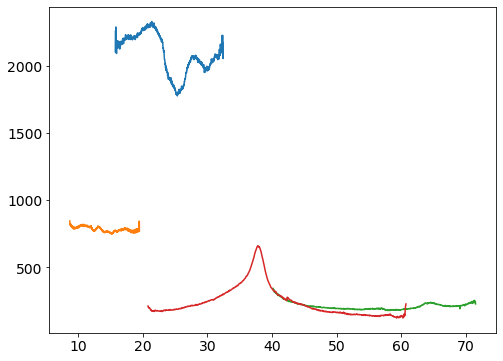

In [11]:
plt.plot(r182_q0_result1d[0],r182_q0_result1d[1]*quad_scale[1])
plt.plot(r182_q1_result1d[0],r182_q1_result1d[1]*quad_scale[0])
plt.plot(r182_q2_result1d[0],r182_q2_result1d[1]*quad_scale[3])
plt.plot(r182_q3_result1d[0],r182_q3_result1d[1]*quad_scale[2])

In [ ]:
run_182 = integrate1d(182,3,dir_data,poni_file_q3,q3_mask)
file_name = 'tmp.xy'
np.savetxt(file_name,run_182.T)
print(run_182.T)

inst_file = '../../.data_LW03/instprm/LW03.instprm'
cif_file = '../../.data_LW03/cif/diamond.cif'

In [ ]:
r182_q2 = np.loadtxt("../../.data_LW03/lineouts/r182_Q2.xy").T
r182_q3 = np.loadtxt("../../.data_LW03/lineouts/r182_Q3.xy").T
merged_xy = merge_four_quads([np.array(r182_q2_result1d),np.array(r182_q3_result1d)],scale=[quad_scale[2],quad_scale[3]])
#merged_xy = merge_four_quads([np.array(r182_q0_result1d),np.array(r182_q1_result1d),np.array(r182_q2_result1d),np.array(r182_q3_result1d)],scale=quad_scale)
r182_Q23 = np.loadtxt("../../.data_LW03/lineouts/r182_Q23.xy").T

In [ ]:
def residual(pars, x, data=None, eps=None):
    # unpack parameters: extract .value attribute for each parameter
    parvals     = pars.valuesdict()
    slope       = parvals['scale']
    intercept   = parvals['intercept']
    amp_gauss   = parvals['amp_gauss']
    cen_gauss   = parvals['cen_gauss']
    wid_gauss   = parvals['wid_gauss']
    amp_lor     = parvals['amp_lor'] 
    cen_lor     = parvals['cen_lor']
    wid_lor     = parvals['wid_lor']
    amp_lor2    = parvals['amp_lor2']
    cen_lor2    = parvals['cen_lor2']
    wid_lor2    = parvals['wid_lor2']

    model = lin_gauss_2lorentzian(x, slope,intercept,amp_gauss, cen_gauss, wid_gauss, amp_lor, cen_lor, wid_lor, amp_lor2, cen_lor2, wid_lor2)

    if data is None:
        return model
    if eps is None:
        return (model - data)
    return (model-data) / eps

In [ ]:
def fit_double_peak(data):
    twoTheta, I = data[0], data[1]
    fit_params          = Parameters()
    fit_params.add('scale', value=0.01)
    fit_params.add('intercept', value=200.)
    fit_params.add('amp_gauss', value=1.)
    fit_params.add('cen_gauss', value=30.9)
    fit_params.add('wid_gauss', value=0.9)
    fit_params.add('amp_lor', value=0.9)
    fit_params.add('cen_lor', value=37.)
    fit_params.add('wid_lor', value=0.9)
    fit_params.add('amp_lor2', value=66.)
    fit_params.add('cen_lor2', value=0.9)
    fit_params.add('wid_lor2', value=0.9)
    

    out                 = minimize(residual, fit_params, args=(twoTheta,), kws={'data': I});
    param_dict          = out.params.valuesdict()
    return out, param_dict

In [ ]:
def fit_diamond(data):

    background = PolynomialModel(degree=6, prefix='bkg_')
    pars = background.guess(data[1], x=data[0])

    pars['bkg_c0'].set(value=16799.19664812164)
    pars['bkg_c1'].set(value=-2443.7057011741654)
    pars['bkg_c2'].set(value=143.47991288976363)
    pars['bkg_c3'].set(value=-4.437331503660367)
    pars['bkg_c4'].set(value=0.06406413001804905)
    pars['bkg_c5'].set(value=-0.0005790101205373556)
    pars['bkg_c6'].set(value=1.9176364963173686e-06)

    peak1 = LorentzianModel(prefix='C111_')
    pars.update(peak1.make_params())

    pars['C111_center'].set(value=39, min=30, max=40)
    pars['C111_sigma'].set(value=2.22)
    pars['C111_amplitude'].set(value=3143.81863)

    peak2 = LorentzianModel(prefix='C220_')
    pars.update(peak2.make_params())

    pars['C220_center'].set(value=63.9, min=60, max=67)
    pars['C220_sigma'].set(value=2.5, max=3.7)
    pars['C220_amplitude'].set(value=1000, min=0.)

    PET_peak = LorentzianModel(prefix='PET_')
    pars.update(PET_peak.make_params())

    pars['PET_center'].set(value=27, min=25, max=29.)
    pars['PET_sigma'].set(value=1.5, max=2.5)
    pars['PET_amplitude'].set(value=1000, min=0.)

    model = peak1 + peak2 + background + PET_peak

    init = model.eval(pars, x=data[0])
    out = model.fit(data[1], pars, x=data[0])

    # print(out.fit_report)

    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(data[0], data[1],label='XRD data')
    #axes[0].plot(data[0], init, '--', label='initial fit')
    axes[0].plot(data[0], out.best_fit, '-', label='best fit')
    axes[0].set_ylabel(r'$I$')
    axes[0].set_xlabel(r'$2\theta$')
    axes[0].legend()

    comps = out.eval_components(x=data[0])
    print(out.params.valuesdict())

    axes[1].plot(data[0], data[1])
    axes[1].plot(data[0], comps['C111_'], '--', label='Peak 111')
    axes[1].plot(data[0], comps['C220_'], '--', label='Peak 220')
    axes[1].plot(data[0], comps['bkg_'], '--', label='Background')
    axes[1].plot(data[0], comps['PET_'], '--', label='PET peak')
    #axes[1].set_ylabel(r'$I [au]$')
    axes[1].set_xlabel(r'$2\theta$')
    axes[1].legend()

    plt.show()

    return out, fig


In [ ]:
runs        = [182,186,188,190,192,289]
fits        = [[]] * len(runs)
for run_id, run in enumerate(runs):
    data                    = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
    fits[run_id], fig       = fit_diamond(data)
    fig.savefig(f'../../.data_LW03/figures/r{run}__fit_plot.svg')
    save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')

In [ ]:
runs                = [182,186,188,190,192,289]
d_111_ambient       = 2.04382 
d_220_ambient       = 1.25158
peak_ratios         = np.zeros(len(runs))
d_C111              = np.zeros(len(runs))
d_C220              = np.zeros(len(runs))
strain_111          = np.zeros(len(runs))
strain_220          = np.zeros(len(runs))

for run_id, run in enumerate(runs):
    result = load_modelresult(f'../../.data_LW03/fits/r{run}__modelresult.sav')
    param_dict              = result.params.valuesdict()
    peak_ratios[run_id]     = param_dict['C220_amplitude'] / param_dict['C111_amplitude']

    d_C111[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C111_center'] / 2.)))
    d_C220[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C220_center'] / 2.)))

    strain_111[run_id]      = np.abs(d_111_ambient - d_C111[run_id] * 1e9) / d_111_ambient
    strain_220[run_id]      = np.abs(d_220_ambient - d_C220[run_id] * 1e9) / d_220_ambient

    #data            = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
    #fits[run_id]    = fit_diamond(data)
    #save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')

In [ ]:
d_C111 *1e9

In [ ]:
d_C220 * 1e9

In [ ]:
plt.scatter(probing_times, strain_111, label='Strain 111 peak')
plt.scatter(probing_times, strain_220, label='Strain 220 peak')
plt.legend()

In [ ]:
peak_positions, scaled_int  = peaks_from_file('../../.data_LW03/cif/diamond.txt')
theoretical_int             = scaled_int[1] / scaled_int[0]
print(theoretical_int)

In [ ]:
plt.plot(r182_Q23[0],r182_Q23[1])
out, param_dict = fit_double_peak(r182_Q23)
print(fit_report(out))
plt.plot(r182_Q23[0],lin_gauss_2lorentzian(r182_Q23[0],*list(param_dict.values())))

In [ ]:
param_dict['scale']

In [ ]:
list(param_dict.values())